# Analysis

## 1. Do voters turn up in larger numbers to change the incumbent MP?

Here we consider voter turnout percentage and voter share for the winner

In [67]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
def voter_share_change(current_year, comparison_year, granularity = 0.5):
    inv_gran = 1/granularity
    required_labels = [
        'State_Name',
        'Constituency_No',
        'Constituency_Name',
        'Party',
        'Candidate',
        'Turnout_Percentage',
        'Vote_Share_Percentage'
    ]
    
    df_current = pd.read_csv('./data/{}/winner-data.csv'.format(current_year))[required_labels]
    df_compare = pd.read_csv('./data/{}/winner-data.csv'.format(comparison_year))[required_labels]
    
    intersection_df = pd.merge(df_current, df_compare, on=['State_Name', 'Constituency_No'], how='inner')
    
    # party changes as we have no way of knowing whether incumbent IND endorsed next IND
    party_change_df = intersection_df[intersection_df['Party_x'] != intersection_df['Party_y']]
    party_same_df = intersection_df[intersection_df['Party_x'] == intersection_df['Party_y']]
    
    max_row, max_perc = [], -100
        
    # for changed parties
    changes_dict = {}
    for index, row in party_change_df.iterrows():
        turnout_change = row['Turnout_Percentage_x'] - row['Turnout_Percentage_y']
        
        if (turnout_change > max_perc):
            max_row = row
            max_perc = turnout_change
        
        turnout_change = round(turnout_change * inv_gran) / inv_gran
        new_party = row['Party_x']
        
        if turnout_change in changes_dict:
            changes_dict[turnout_change] += 1
        else:
            changes_dict[turnout_change] = 1 
    x_vals = list(changes_dict.keys())
    x_vals.sort()
    y_vals = [changes_dict[i] for i in x_vals]
    plt.plot(x_vals, y_vals, label="Changed")
    
    # for same parties
    changes_dict = {}
    for index, row in party_same_df.iterrows():
        turnout_change = row['Turnout_Percentage_x'] - row['Turnout_Percentage_y']
        if (turnout_change > max_perc):
            max_row = row
            max_perc = turnout_change
        
        turnout_change = round(turnout_change * inv_gran) / inv_gran
        new_party = row['Party_x']
        
        if turnout_change in changes_dict:
            changes_dict[turnout_change] += 1
        else:
            changes_dict[turnout_change] = 1 
    x_vals = list(changes_dict.keys())
    x_vals.sort()
    y_vals = [changes_dict[i] for i in x_vals]    
    plt.plot(x_vals, y_vals, label="Same")
    
    plt.xlabel('% change')
    plt.ylabel('Number of Occurances')
    plt.legend()
    plt.show()
    
    print('{}, {} saw the highest increase in turnout percentage'.format(max_row['Constituency_Name_x'], max_row['State_Name']))
    if (max_row['Party_x'] == max_row['Party_y']):
        print('\t The incumbent party {} remained.'.format(max_row['Party_x']))
    else:
        print('\t {} was replaced by {}'.format(max_row['Party_y'], max_row['Party_x']))

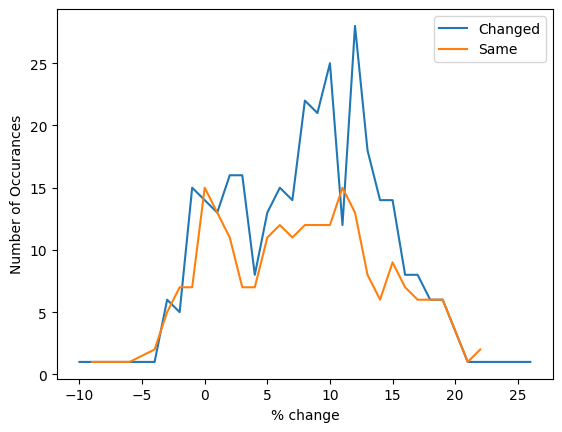

UDHAMPUR, Jammu_&_Kashmir saw the highest increase in turnout percentage
	 INC was replaced by BJP


In [3]:
voter_share_change(2014, 2009, 1)

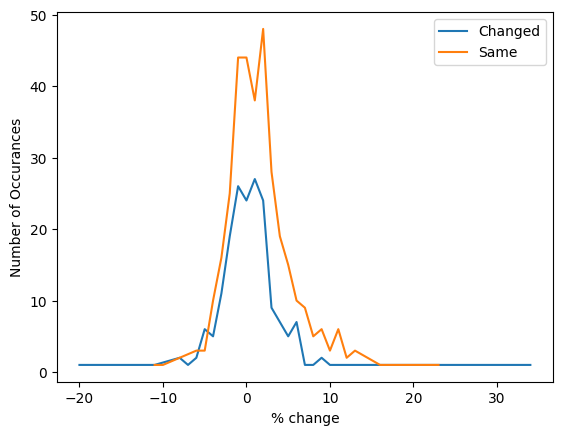

AMALAPURAM, Andhra_Pradesh saw the highest increase in turnout percentage
	 TDP was replaced by YSRCP


In [4]:
voter_share_change(2019, 2014, 1)

### Conclusions

- In the case of 2009 -> 2014, people wished for a change and hence turned up in greater numbers to change the incumbent party
 
    - This is elucidated by the high number of occurances of where a larger trunout of voters led to a change in the party (in general)
    - A large turnout to keep the same party in power can be attributed to the fact that 2014 was a major shift in status quo for NDA and people who wished for the previous party to remain recognized the threat by the competition. 

- In the case of 2014-> 2019, we see that most constituencies didn't wish for change as compared to the previous election cycle.
    
    - However, we see that the people recognized their power and hence turned up to vote in the same numbers as 2014 (more than 2009)
    - Although, several places remained under the same party a few places changed their representatives without changing the voter trunout drastically
        - A closer peek into such places showed that these constituencies had minute differences between the number of votes won by the winner and the runner-up (with a few outliers such as Amethi)

## 2. How likely are SC/ST candidates to win in a general seat?

In [21]:
df = pd.read_csv('./data/All_States_GE.csv', keep_default_na=False)
required_labels = [
    'Candidate_Type',
    'Year',
    'Assembly_No',
]

df_gen = df[df['Constituency_Type'] == 'GEN'][required_labels]
df_gen_corrected = df_gen[df_gen['Candidate_Type'] != '']
# df_gen_corrected = df_gen_corrected[df_gen_corrected['Position'] == 1]

# correcting some data
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'GENERAL', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'general', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'Gen', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'sc', 'Candidate_Type'] = 'SC'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'st', 'Candidate_Type'] = 'ST'

/tmp/ipykernel_31167/4105408214.py:1: DtypeWarning: Columns (11,14,19,20,22,23,24,27,29,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/All_States_GE.csv', keep_default_na=False)


In [22]:
len(df), len(df_gen), len(df_gen_corrected)

(91669, 76617, 23522)

In [23]:
df_gen_corrected.head()

,Candidate_Type,Year,Assembly_No
0,GEN,2019,17
3,GEN,2019,17
11,GEN,2019,17
14,GEN,2019,17
15,GEN,2019,17


In [24]:
# We will only be focussing on data where we have the candidate's type
df_distro = df_gen_corrected.groupby(['Assembly_No', 'Candidate_Type']).size()

In [25]:
assembly_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

freq_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

for row in df_distro.items():
    assembly_num, cd_type, freq = row[0][0], row[0][1], row[1]
    assembly_list[cd_type].append(assembly_num)
    freq_list[cd_type].append(freq)

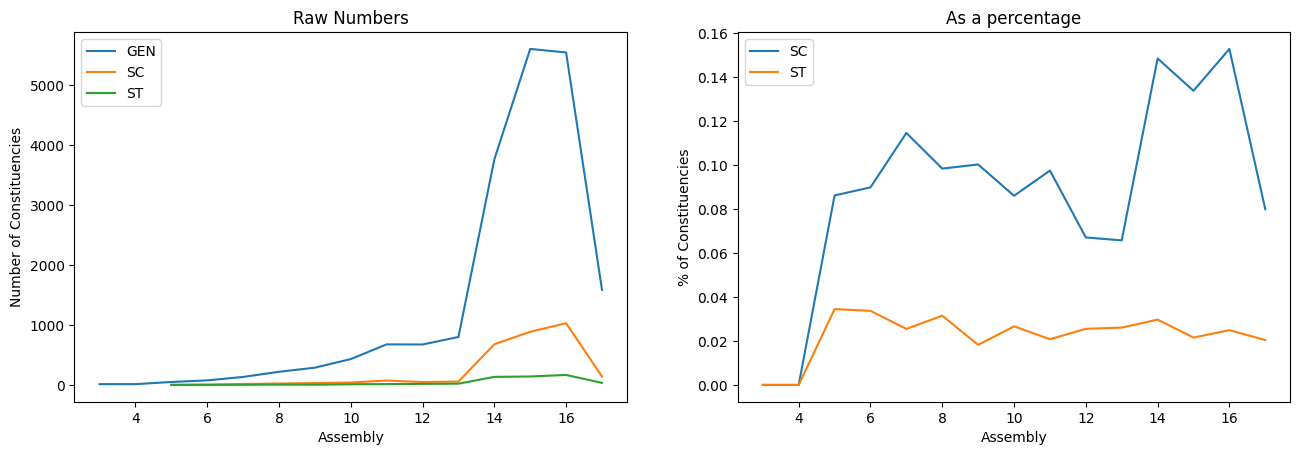

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(left=0.1, right=2, wspace=0.2)
for i in assembly_list.keys():
    axes[0].plot(assembly_list[i], freq_list[i], label=i)
    
tot_assembly_list = []
perc_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

for as_num in assembly_list['GEN']:
    tot_assembly_list.append(as_num)
    perc_list['GEN'].append(0)
    perc_list['SC'].append(0)
    perc_list['ST'].append(0)
    
    for key in perc_list.keys():
        for comp_ind in range(len(assembly_list[key])):
            if (assembly_list[key][comp_ind] == as_num):
                perc_list[key][-1] = freq_list[key][comp_ind]
            
    st_num, sc_num, gen_num = perc_list['ST'][-1], perc_list['SC'][-1], perc_list['GEN'][-1]
    perc_list['ST'][-1] = st_num/(st_num + sc_num + gen_num)
    perc_list['SC'][-1] = sc_num/(st_num + sc_num + gen_num)
    perc_list['GEN'][-1] = gen_num/(st_num + sc_num + gen_num)
    

for i in perc_list.keys():
    if (i != 'GEN'):
        axes[1].plot(tot_assembly_list, perc_list[i], label=i)

axes[0].set_title("Raw Numbers")
axes[0].set_xlabel('Assembly')
axes[0].set_ylabel('Number of Constituencies')
axes[0].legend()

axes[1].set_title("As a percentage")
axes[1].set_xlabel('Assembly')
axes[1].set_ylabel('% of Constituencies')
axes[1].legend()

plt.show()

### This was for how likely is it for SC/ST candidates to stand for elections in a general seat

As we can see this number hasn't significantly changes over the years (percentage) and can just be attributed to reasons we can analyze later.

/tmp/ipykernel_31167/3138886059.py:1: DtypeWarning: Columns (11,14,19,20,22,23,24,27,29,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/All_States_GE.csv', keep_default_na=False)


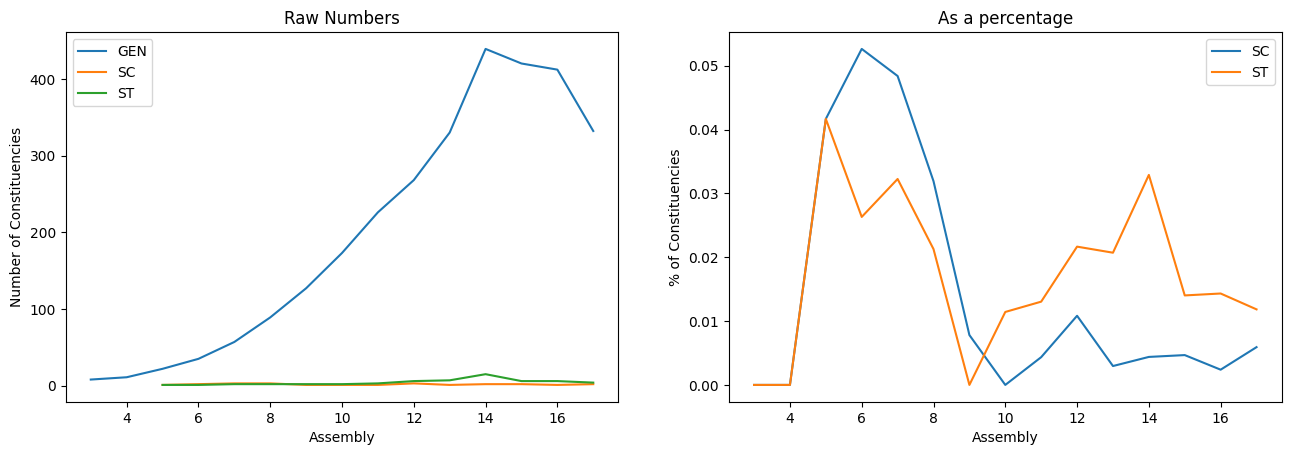

In [29]:
df = pd.read_csv('./data/All_States_GE.csv', keep_default_na=False)
required_labels = [
    'Candidate_Type',
    'Year',
    'Assembly_No',
    'Position'
]

df_gen = df[df['Constituency_Type'] == 'GEN'][required_labels]
df_gen_corrected = df_gen[df_gen['Candidate_Type'] != '']
df_gen_corrected = df_gen_corrected[df_gen_corrected['Position'] == 1]

# correcting some data
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'GENERAL', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'general', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'Gen', 'Candidate_Type'] = 'GEN'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'sc', 'Candidate_Type'] = 'SC'
df_gen_corrected.loc[df_gen_corrected['Candidate_Type'] == 'st', 'Candidate_Type'] = 'ST'

# We will only be focussing on data where we have the candidate's type
df_distro = df_gen_corrected.groupby(['Assembly_No', 'Candidate_Type']).size()

assembly_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

freq_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

for row in df_distro.items():
    assembly_num, cd_type, freq = row[0][0], row[0][1], row[1]
    assembly_list[cd_type].append(assembly_num)
    freq_list[cd_type].append(freq)
    
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(left=0.1, right=2, wspace=0.2)
for i in assembly_list.keys():
    axes[0].plot(assembly_list[i], freq_list[i], label=i)
    
tot_assembly_list = []
perc_list = {
    'GEN': [],
    'SC': [],
    'ST': []
}

for as_num in assembly_list['GEN']:
    tot_assembly_list.append(as_num)
    perc_list['GEN'].append(0)
    perc_list['SC'].append(0)
    perc_list['ST'].append(0)
    
    for key in perc_list.keys():
        for comp_ind in range(len(assembly_list[key])):
            if (assembly_list[key][comp_ind] == as_num):
                perc_list[key][-1] = freq_list[key][comp_ind]
            
    st_num, sc_num, gen_num = perc_list['ST'][-1], perc_list['SC'][-1], perc_list['GEN'][-1]
    perc_list['ST'][-1] = st_num/(st_num + sc_num + gen_num)
    perc_list['SC'][-1] = sc_num/(st_num + sc_num + gen_num)
    perc_list['GEN'][-1] = gen_num/(st_num + sc_num + gen_num)
    

for i in perc_list.keys():
    if (i != 'GEN'):
        axes[1].plot(tot_assembly_list, perc_list[i], label=i)

axes[0].set_title("Raw Numbers")
axes[0].set_xlabel('Assembly')
axes[0].set_ylabel('Number of Constituencies')
axes[0].legend()

axes[1].set_title("As a percentage")
axes[1].set_xlabel('Assembly')
axes[1].set_ylabel('% of Constituencies')
axes[1].legend()

plt.show()

### Conclusion

We see that 
- Despite the number of SC/ST candidates standing for elections in a GEN seat, the actual number who win is actually pretty less indicating that major parties tend not to field candidates in such a manner.
- We cannot comment on the slight increase in raw number in the 14th General Assembly as it balances out percentage wise and is comparable to the surrounding years
- The amount of SC candidates and ST candidates _winning_ started becoming slightly significant with the 5th Lok Sabha (Janata Party) and INC continued this trend fielding powerful SC/ST candidates from the 6th Lok Sabha (Powerful as the actual number of SC/ST candidates standing for a general seat didn't change)
    - BUT, this was also the first year where parties 
- There were significant dips in the 9th and 10th Lok Sabhas post which the major political parties in India stopped fielding such candidates as part of their ticket giving stategy (but it must be noted that the maximum percentage in the graph corresponds to just a handful of candidates

## 3. What were the effects of changing party between 2009-14 and 2014-19?

In [183]:
def voter_share_change(current_year, comparison_year, cutoff = 0.5):
    required_labels = [
        'Party',
        'Candidate',
        'Vote_Share_Percentage',
    ]
    
    df_current = pd.read_csv('./data/{}/full-data.csv'.format(current_year))[required_labels]
    df_compare = pd.read_csv('./data/{}/full-data.csv'.format(comparison_year))[required_labels]
    
    intersection_df = pd.merge(df_current, df_compare, on=['Candidate'], how='inner')
    
    intersection_df = intersection_df[intersection_df['Party_x'] != intersection_df['Party_y']]
    intersection_df = intersection_df[abs(intersection_df['Vote_Share_Percentage_x'] - intersection_df['Vote_Share_Percentage_y']) >= cutoff]
    
    old_parties = intersection_df['Party_y'].unique()
    new_parties = intersection_df['Party_x'].unique()
    
    old_parties.sort()
    new_parties.sort()
    
    # print(old_parties, new_parties)
    # print(intersection_df)
    
    old_p_dict = {}
    new_p_dict = {}

    counter = 0
    for i in old_parties:
        old_p_dict[i] = counter
        counter+=1
        
    counter = 0
    for i in new_parties:
        new_p_dict[i] = counter
        counter+=1
        
    x, y_1, y_2 = [], [], []
    
    for index, row in intersection_df.iterrows():
        old_party, new_party = old_p_dict[row['Party_y']], new_p_dict[row['Party_x']]
        
        found = False
        for i in range(len(x)):
            if x[i] == old_party and y_1[i] == new_party:
                found = True
                y_2[i].append(row['Vote_Share_Percentage_x'] - row['Vote_Share_Percentage_y'])
                
        if (not found):
            x.append(old_party)
            y_1.append(new_party)
            y_2.append([row['Vote_Share_Percentage_x'] - row['Vote_Share_Percentage_y']])
            
    for i in range(len(y_2)):
        y_2[i] = sum(y_2[i])/len(y_2[i])
        
        
    # color scatterplot code from https://rowannicholls.github.io/python/graphs/ax_based/scatterplots.html
    cmap = matplotlib.colormaps['plasma']
    normalize = matplotlib.colors.Normalize(vmin=min(y_2), vmax=max(y_2))
    colors = [cmap(normalize(value)) for value in y_2]        

    # Create axes
    plt.figure(figsize=(50,50))
    ax = plt.axes()
    ax.scatter(x, y_1, s=400, c=colors, marker='o')
    ax.set_title('Effect of changing party')
    
    ax.set_xticklabels(ax.get_xticks(), rotation =90, fontsize=25)
    ax.set_xticks(list(range(len(old_parties))), old_parties)
    
    ax.set_yticklabels(ax.get_yticks(), fontsize=25)
    ax.set_yticks(list(range(len(new_parties))), new_parties)
    
    ax.set_ylabel('New Party', fontsize=35)
    ax.set_xlabel('Old Party', fontsize=35)
    
    cax, _ = matplotlib.colorbar.make_axes(ax, shrink=0.5, fontsize=35)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
    cbar.ax.tick_params(labelsize=30)
    cbar.ax.set_ylabel('Change in voter share', fontsize=30)

    plt.show()
        

/tmp/ipykernel_31167/4005632656.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation =90, fontsize=25)
/tmp/ipykernel_31167/4005632656.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


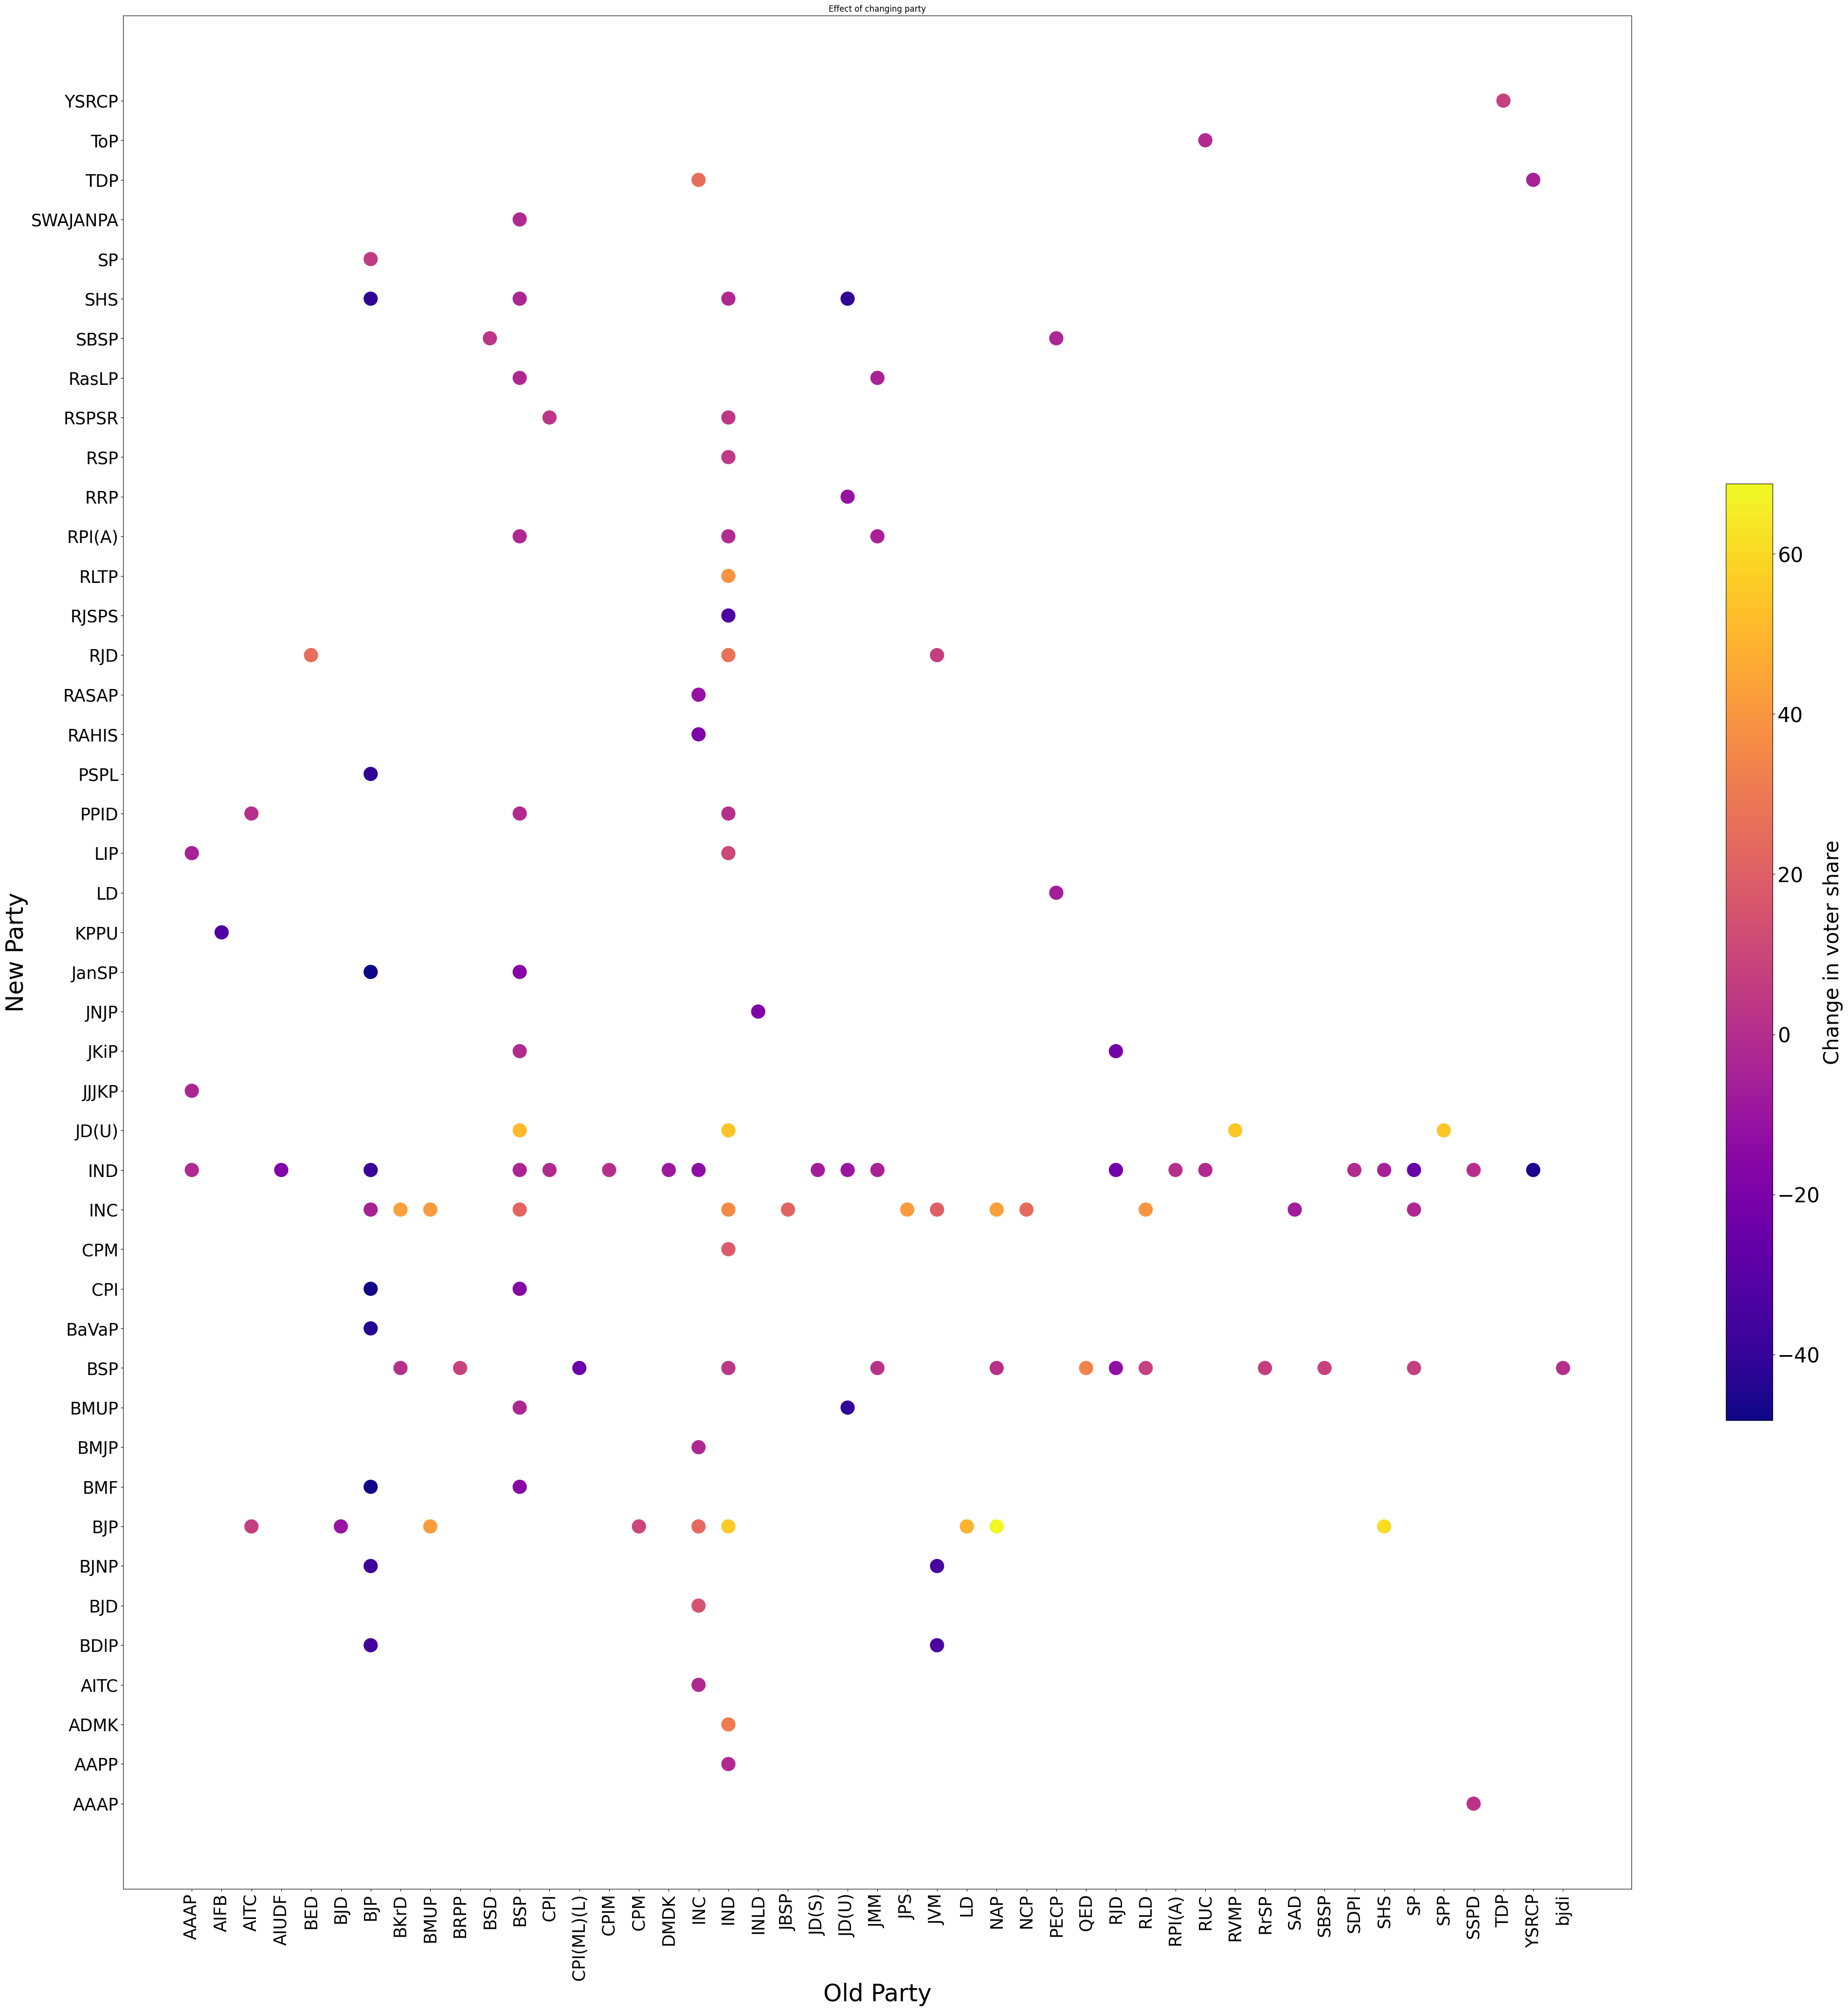

In [184]:
voter_share_change(2019, 2014, 1)

/tmp/ipykernel_31167/4005632656.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation =90, fontsize=25)
/tmp/ipykernel_31167/4005632656.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


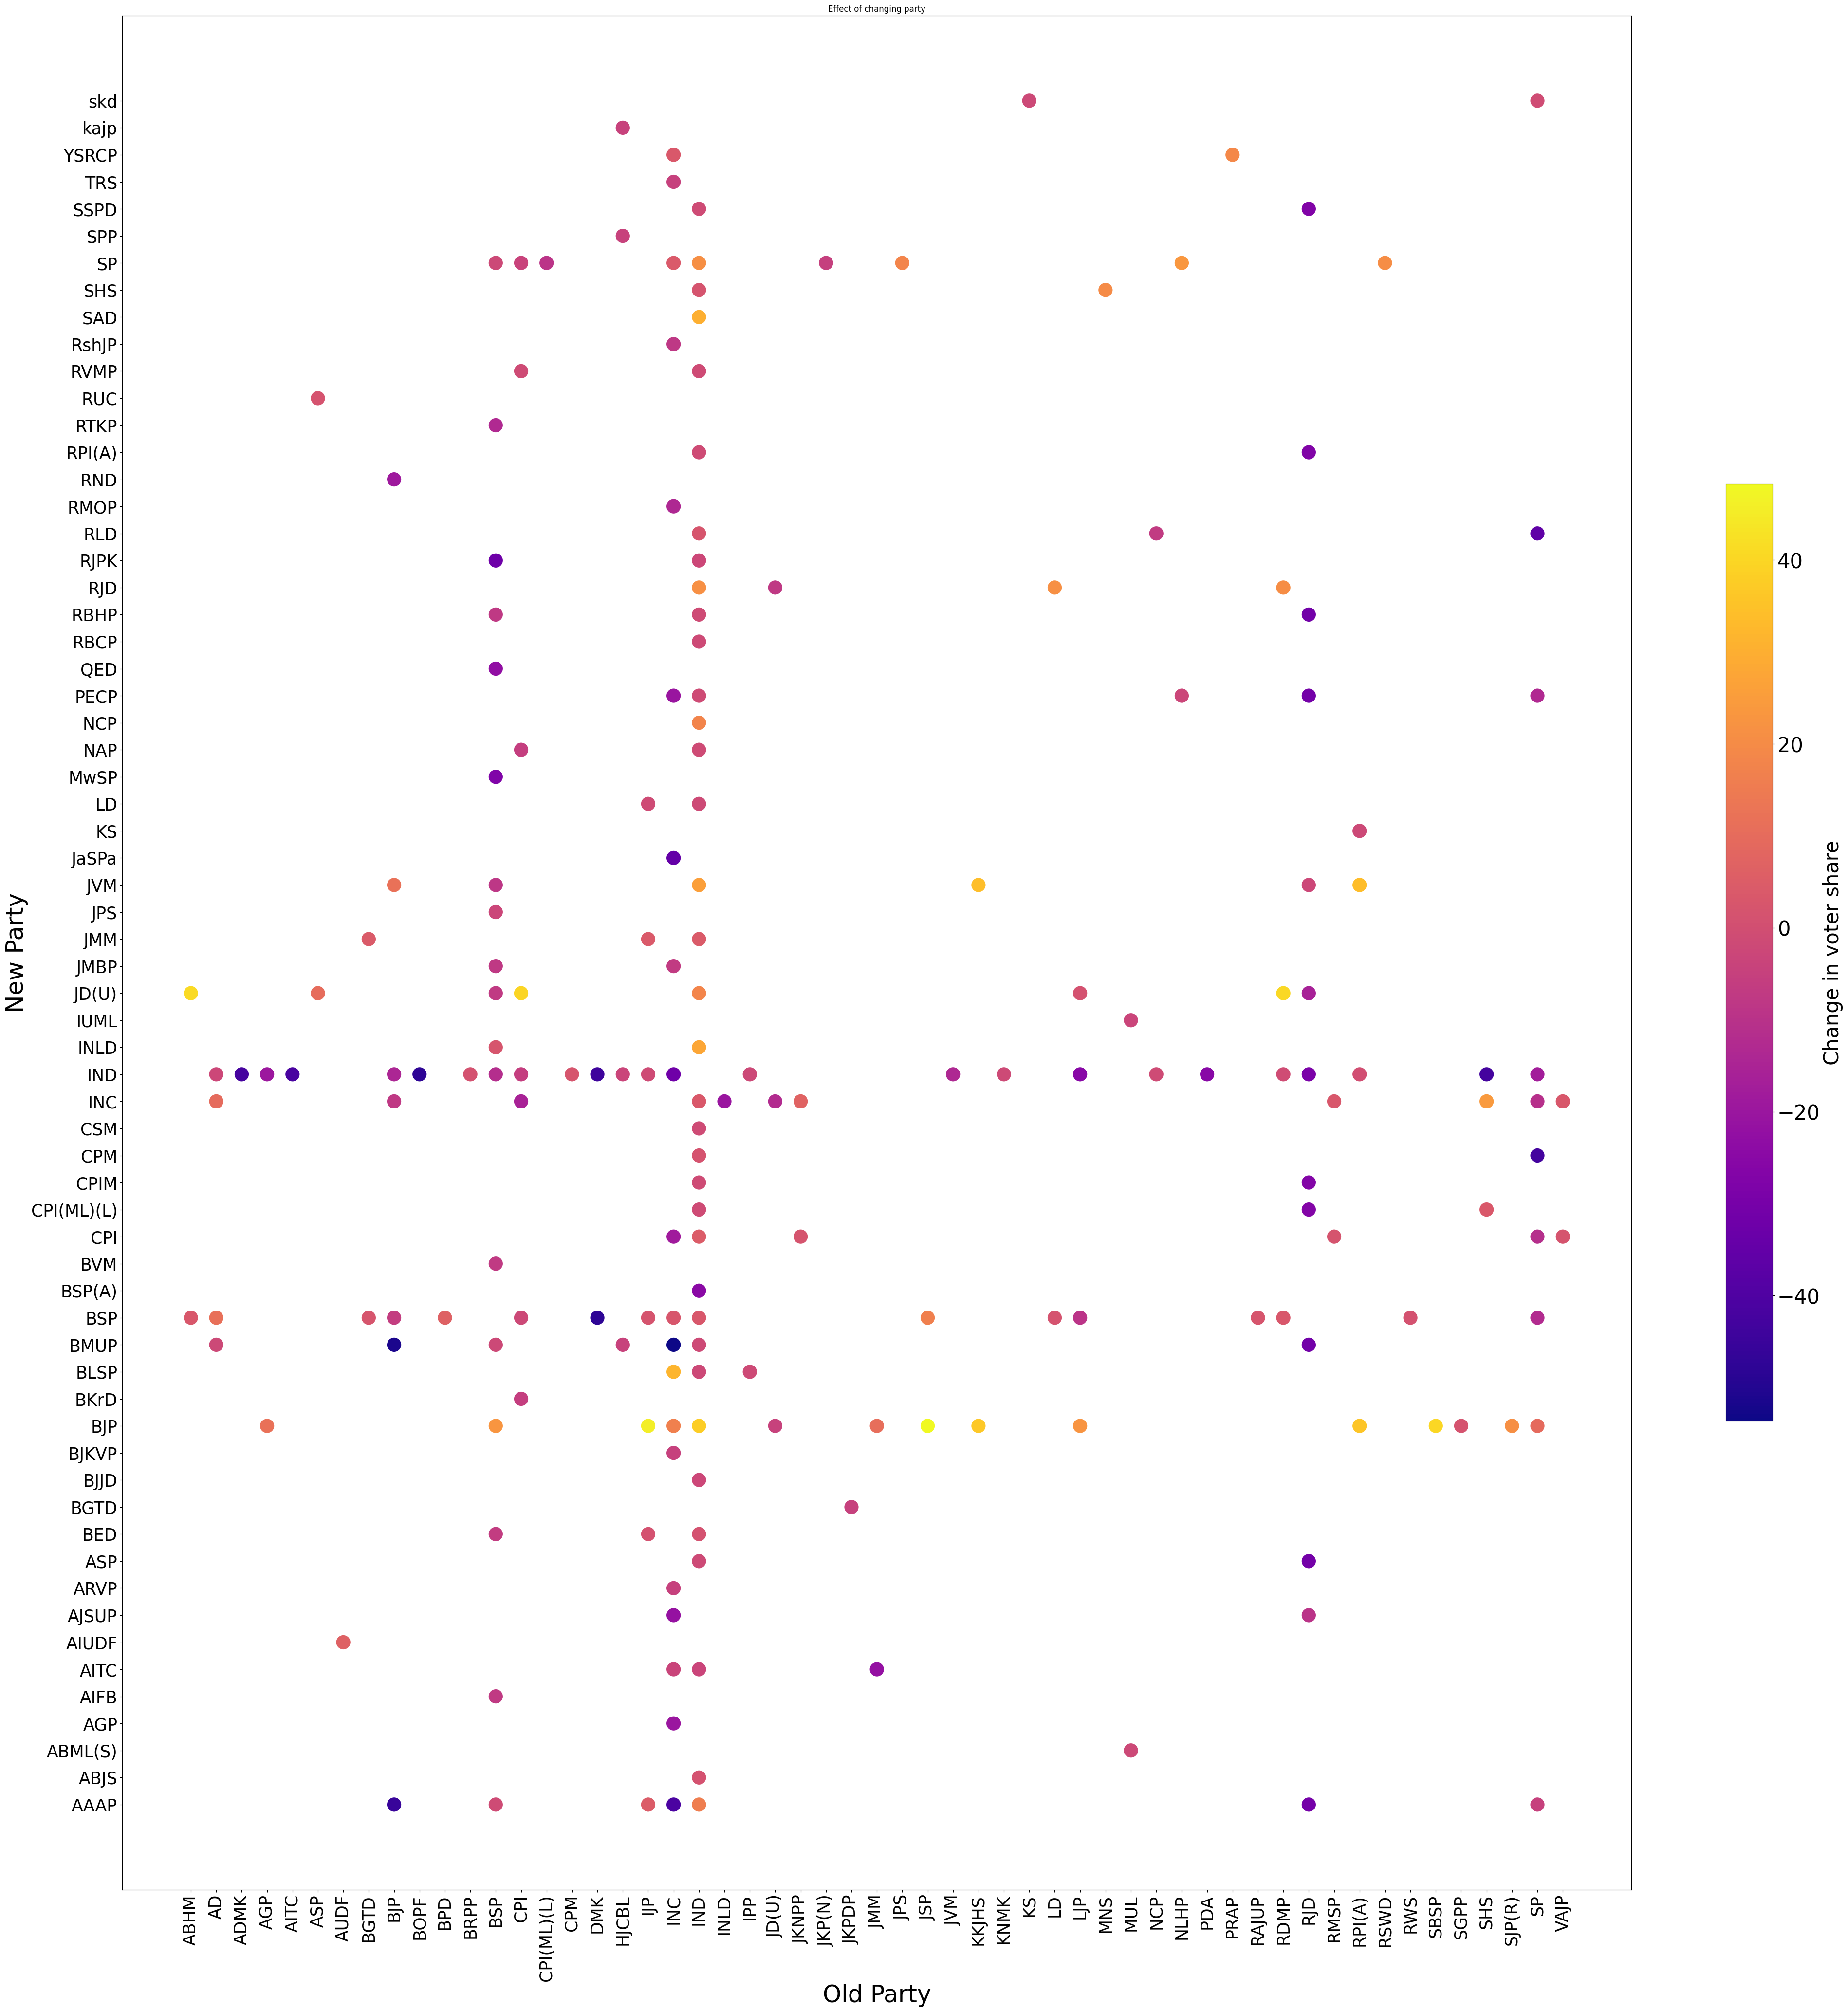

In [185]:
voter_share_change(2014, 2009, 1)

### Conclusions

1. In 2019
    - Those who became Independent or joined BSP saw tremendous loss in voter share showing the growing tendency towards major national parties (which started in 2014)
    - Multiple candidates who shifted from smaller parties to INC were greeted with an increase in voter share which is further supported by INC increasing its number of constituencies in 2019.
    - Candidates who moved out of BJP lost a majority of their voter share showing that BJP as a party was the major influence and not individual MPs.


2. In 2014
    - Independents cannot be judged as both people shifting into IND and moving out suffered losses. However, a good chunk of people moving out of IND also gained a lot of support but those moving into IND mainly lost shares.
    - People who shifted into BJP gained very large margins as the year indicated a shift in INC to BJP across the nation.
    - People who shifted into BSP lost tremendously as its major constituencies were lost to BJP